# Baseline

To create a baseline to compare our class introspection technique to, lets simply try ignoring the explanation components and simply run the PCA + DBSCAN over the dataset directly.


In [1]:
# run configuration
BRIDGED = (0,1)
# EPSILON = 6
EPSILON = 275

## Setup

Load MNIST, generate test+val split.

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 9]
plt.rcParams['font.size'] = 18

import random
import pickle
import os
import math
from nbcache import cacheable
from tqdm.notebook import tqdm

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.stats import norm


@cacheable('mnist.pickle')
def get_mnist():
    return fetch_openml('mnist_784', data_home='../datasets')

mnist = get_mnist()

'''
# cache locally
if not os.path.exists('./mnist.pickle'):
    print('No cached MNIST data, downloading...')
    mnist = fetch_openml('mnist_784', data_home='../datasets')
    pickle.dump(data, open('./mnist.pickle', 'wb'))
else:
    print('Unpacking MNIST from cache...')
    mnist = pickle.load(open('./mnist.pickle', 'rb'))
'''
print(mnist.DESCR)

Loading from cache mnist.pickle...
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the imag

In [3]:
import numpy as np

# training data
X_trn = mnist.data.iloc[0:60000].to_numpy().astype('float32')
X_trn = X_trn.reshape(X_trn.shape[0], 28, 28) # reshape to images
y_trn = mnist.target.iloc[0:60000].to_numpy().astype('float32')

y_trn = np.vstack([y for y in y_trn]) # jankily turn this into a column vector

# test data
X_tst = mnist.data.iloc[60000:70000].to_numpy().astype('float32')
X_tst = X_tst.reshape(X_tst.shape[0], 28, 28) # reshape to images
y_tst = mnist.target.iloc[60000:70000].to_numpy().astype('float32')
y_tst = np.vstack([y for y in y_tst])

## Generate bridged classes

In [4]:
y_tst_hw = [(y if y != BRIDGED[1] else BRIDGED[0]) for y in y_tst.T[0]]
y_tst_hw = np.vstack([y for y in y_tst_hw])

We do not need to filter for only the correct explanations (as before) because we are only considering the one class.

## Generate PCA components

*this is pretty much directly copy-pasted from `./Alt Postprocessing.ipynb`*

In [5]:
pca = PCA(n_components=5)
# batch_tfrm = pca.fit_transform([np.log(e.flatten() + 1) for e in X_tst])
batch_tfrm = pca.fit_transform([e.flatten() for e in X_tst])

In [6]:
batch_tfrm.T[0]

array([-411.2609117 ,   58.06671032, -935.10530528, ..., -282.41574424,
       -287.27044749, 1144.16993198])

### Sidebar : PCA components investigation

what sort of DBSCAN epsilon should we pick here?

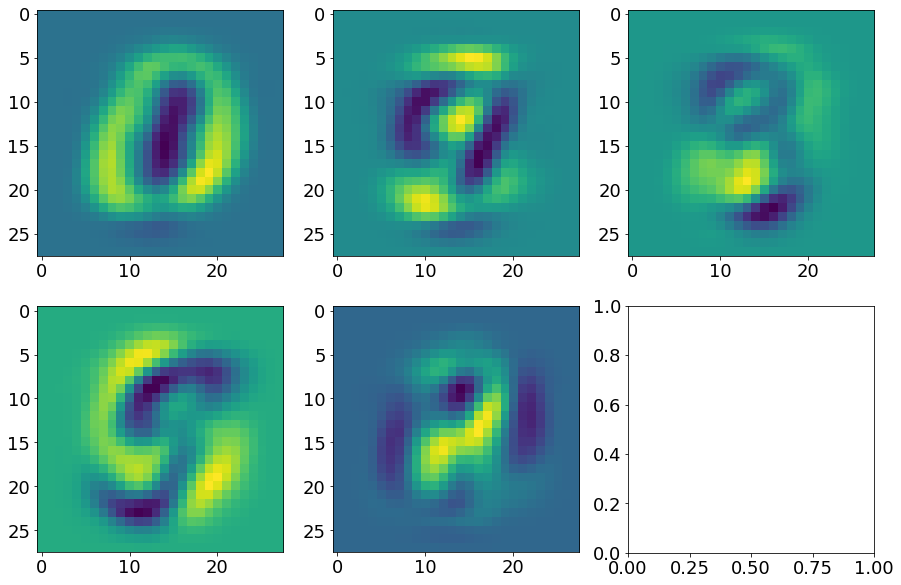

In [7]:
plt.rcParams['figure.figsize'] = [15, 10]

fig, axs = plt.subplots(2,3)
axs_r = axs.ravel() # iterate over these without structure

# zip together the axes with the labels that go on them
for comp, ax in zip(pca.components_, axs_r):
    ax.imshow(comp.reshape(28,28))

plt.show()

Mean:   -8.73114913702011e-15
Stddev: 587.608429972807


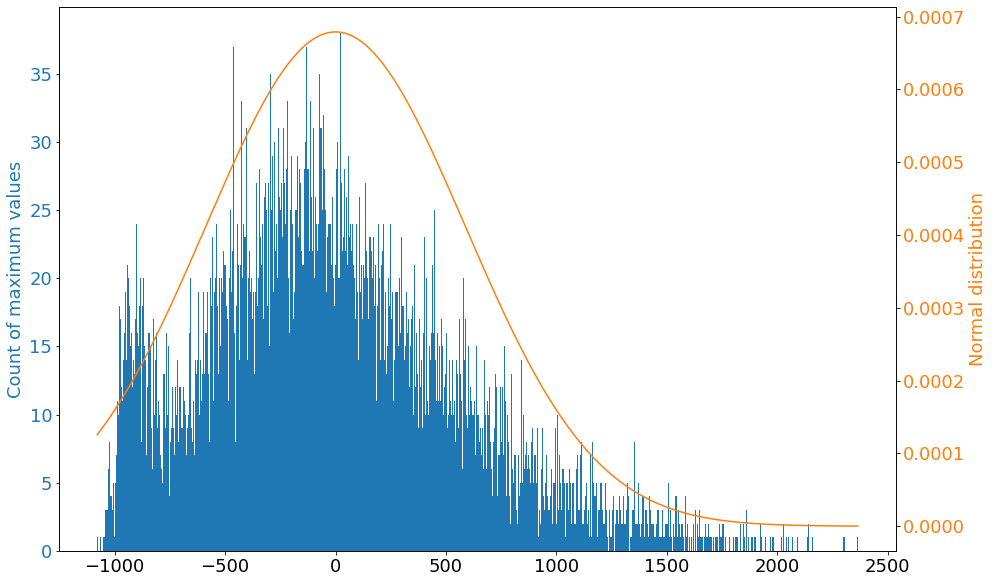

In [8]:
# pyplot setup
fig, ax1 = plt.subplots()

c1 = batch_tfrm.T[0]
mean = np.mean(c1)
stddev = np.std(c1)

print(f'Mean:   {mean}')
print(f'Stddev: {stddev}')

# histogram of maximum values
color = 'tab:blue'
ax1.hist(c1, bins=1000, label='histogram of data', color=color)
ax1.set_ylabel('Count of maximum values', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# second plot
ax2 = ax1.twinx()

# attempt to draw a normal distribution (likely too small)
color = 'tab:orange'
x_axis = np.arange(np.amin(c1) - 0.5, np.amax(c1), 1)
ax2.plot(x_axis, norm.pdf(x_axis,mean,stddev), color=color)
ax2.set_ylabel('Normal distribution', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

## Cluster over the components

In [9]:
def get_transformed_instances(lbl):
    bt_indices, _ = np.where(y_tst_hw == lbl)
    return batch_tfrm[bt_indices]

def create_single_graph(ax, lbl, epsilon, silent=False):
#     bt_indices, _ = np.where(y_tst_hw_filtered == lbl)
    bt_lbl = get_transformed_instances(lbl)
    
    dbscan = DBSCAN(eps=epsilon)
    vals = dbscan.fit_predict(bt_lbl)
    
    if not silent:
        print(''.join([str(abs(v)) for v in vals]))

    # heavy wizardry to indicate noise
    _, _, patches = ax.hist(vals, label=f'{int(lbl)}')
    patches[0].set_facecolor('gray')
    ax.legend()
    return ax

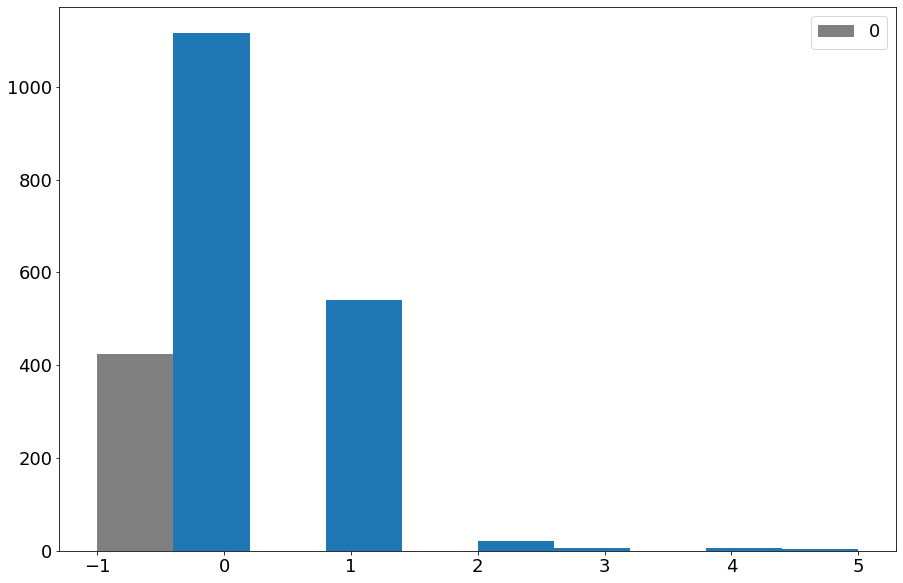

In [10]:
create_single_graph(plt, 0, EPSILON, silent=True)
plt.show()

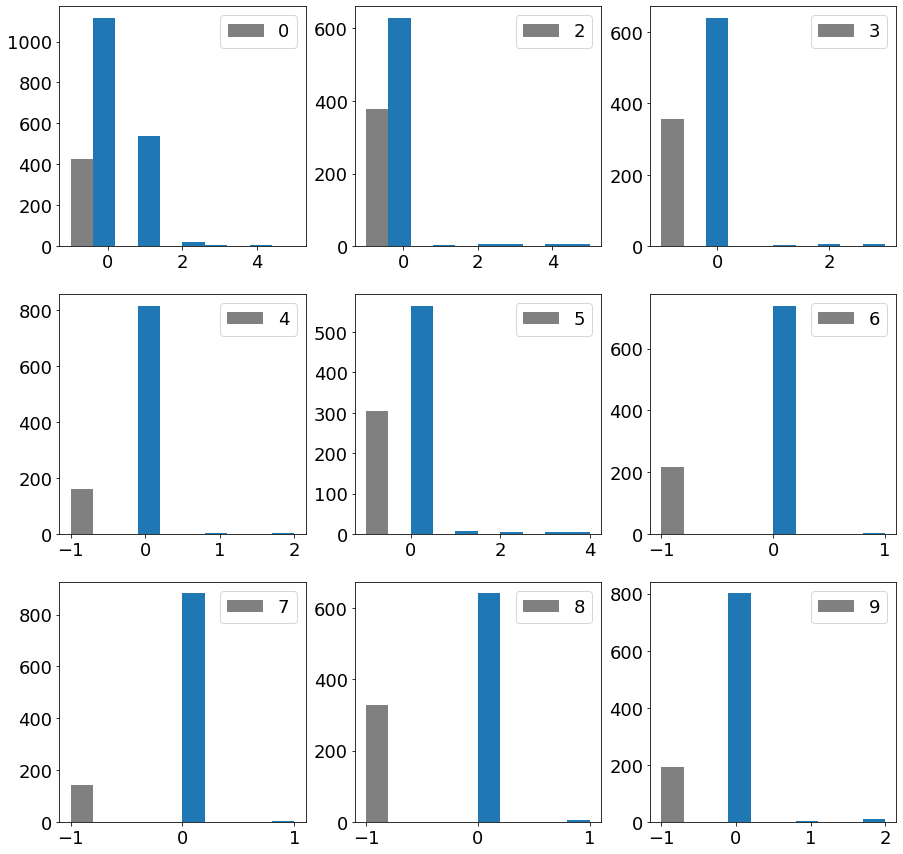

In [11]:
# one big graph
plt.rcParams['figure.figsize'] = [15, 15]

fig, axs = plt.subplots(3,3)
axs_r = axs.ravel() # iterate over these without structure

# zip together the axes with the labels that go on them
for lbl, ax in zip(np.unique(y_tst_hw), axs_r):
    create_single_graph(ax, lbl, EPSILON, silent=True)

plt.show()